In [25]:
# ! pip install pdf2image
# ! pip install pytesseract

! pip install -U langchain openai chromadb langchain-experimental   
# (newest versions required for multi-modal)

# ! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

   ---------------------------------------- 0.0/202.5 kB ? eta -:--:--
   -- ------------------------------------- 10.2/202.5 kB ? eta -:--:--
   ----- --------------------------------- 30.7/202.5 kB 445.2 kB/s eta 0:00:01
   --------- ----------------------------- 51.2/202.5 kB 375.8 kB/s eta 0:00:01
   -------------------------------------- - 194.6/202.5 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 202.5/202.5 kB 1.1 MB/s eta 0:00:00


In [1]:
from langchain_community.llms import Ollama

llm = Ollama(
    model="llava"
)  # assuming you have Ollama installed and have llama3 model pulled with `ollama pull llama3 `

llm.invoke("Tell me a joke")

' Why was the math book sad? Because it had too many problems. '

In [3]:
import os
import shutil
os.mkdir("Data")
# ! wget "https://www.getty.edu/publications/resources/virtuallibrary/0892360224.pdf"
shutil.move("test.pdf","Data")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'Data'

In [4]:
path = r"Data/"
#
file_name = os.listdir(path)
print(file_name)

['test_50.pdf']


In [ ]:
!pip install pytesseract

In [6]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [10]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=path + file_name[0],
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,)

In [18]:
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

print(len(tables))
print(len(texts))

0
182


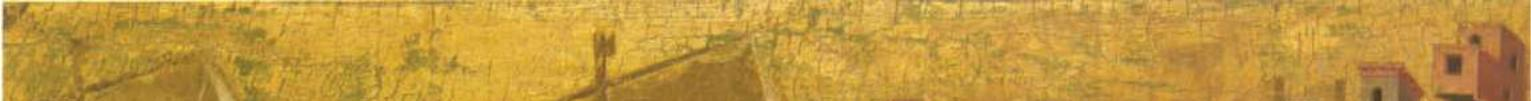

In [19]:
from PIL import Image
Image.open("Data/figure-2-1.jpg")

In [24]:
import numpy
numpy.version.version

'1.26.4'

In [23]:
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="llava")
print(embeddings)

base_url='http://localhost:11434' model='llava' embed_instruction='passage: ' query_instruction='query: ' mirostat=None mirostat_eta=None mirostat_tau=None num_ctx=None num_gpu=None num_thread=None repeat_last_n=None repeat_penalty=None temperature=None stop=None tfs_z=None top_k=None top_p=None show_progress=False headers=None model_kwargs=None


In [26]:
import os
import uuid

import chromadb
import numpy as np
from langchain.vectorstores import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

In [ ]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [ ]:
from operator import itemgetter

from langchain.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough,RunnableParallel


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please use your extensive knowledge and analytical skills to provide a "
            "comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]